In [66]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import scipy.stats as stat
from pandas.tseries.offsets import MonthBegin, MonthEnd
from dateutil.relativedelta import relativedelta

In [452]:
company_list = ['삼성', '네이버', '두산중공업', '롯데칠성', 'SK네트웍스', '셀트리온헬스케어', '현대건설', '코미팜', '제주항공']

In [446]:
def calc_vol(company_name):
    file = company_name+'.csv'
    data = pd.read_csv('./raw_data/' + file)
    data
    data['date'] = pd.to_datetime(data['date'], format = '%Y.%m.%d %H:%M')
    data.index = data.date 
    data.sort_index(inplace=True)
#     data.drop("date", inplace=True, axis =1 )
    half_len = len(data.date.resample("m"))/2
    half_len_round = int(np.round(half_len))
    half_len_df = data.date.resample("m").count().iloc[:half_len_round].sum()
    front_vol = data[:half_len_df].close.resample("d").last().pct_change().std() * np.sqrt(252)
    back_vol = data[half_len_df:].close.resample("d").last().pct_change().std() * np.sqrt(252)
    total_vol = data[:].close.resample("d").last().pct_change().std() * np.sqrt(252)
    print(company_name + " 변동성추정&투자기간(1년) 변동성")
    print("전기(6개월) 변동성 : ", front_vol)
    print("후기(6개월) 변동성 : ", back_vol)
    print("총 기간(1년) 변동성 : ", total_vol)
    data.close.plot(color = 'blue')
    plt.show()
    
    return data.close

front_vol  0.32814852106807696
back_vol  0.2619066354598787
total_vol  0.2974295409932259


date
2019-10-01 09:00:00    137500
2019-10-01 09:01:00    137000
2019-10-01 09:06:00    136500
2019-10-01 09:07:00    137000
2019-10-01 09:08:00    137000
                        ...  
2020-10-06 15:16:00     88800
2020-10-06 15:17:00     88900
2020-10-06 15:18:00     88900
2020-10-06 15:19:00     88800
2020-10-06 15:30:00     88800
Name: close, Length: 88062, dtype: int64

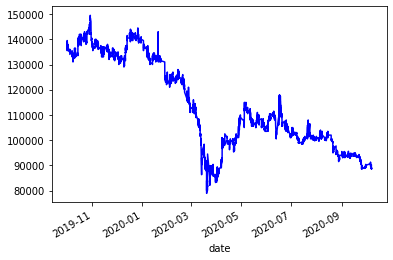

In [407]:
calc_vol('제주항공')

In [458]:
company_name = '제주항공'
data = pd.read_csv('./raw_data/'+ company_name + '.csv')

In [459]:
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2019-10-01 09:00:00,22613
1,2019-10-01 09:01:00,22886
2,2019-10-01 09:02:00,22704
3,2019-10-01 09:03:00,22749
4,2019-10-01 09:04:00,22704


Real volatility는 쓰기 힘들듯.. 단위 자체가 다르네..

## Historical volatility

In [362]:
def historical_vol(price_df, now): # dataframe(columns = ['datetime', price(minute)]), TimeStamp
    """
        최근 6개월 간의 데이터를 바탕으로 annual vol을 구해줌.
    """
    tmp = price_df.copy()
    tmp['date'] = pd.to_datetime(tmp['date'])
    begin_date = now - relativedelta(months=6)
    end_date = str(now.date())
    tmp = tmp[(tmp['date'] >= begin_date) & (tmp['date'] < end_date)]
    tmp.set_index('date', inplace = True)
    res = tmp.resample('d').last().pct_change().std() * np.sqrt(252)
    return res

# EWMA

In [394]:
temp = data.copy()
temp['date'] = pd.to_datetime(temp['date'])
temp = temp.set_index('date')
temp


,close
date,
2019-10-01 09:00:00,46450
2019-10-01 09:01:00,46400
2019-10-01 09:02:00,46450
2019-10-01 09:03:00,46600
2019-10-01 09:04:00,46600
...,...
2020-10-05 15:08:00,30850
2020-10-05 15:09:00,30800
2020-10-05 15:10:00,30800


0

In [328]:
def daily_vol(price_df, now): # dataframe(columns = ['datetime', price(minute)]), TimeStamp
    """
        ewma으로 annual vol을 구해줌.
    """
    tmp = price_df.copy()
    now = pd.to_datetime(now).date()
    tmp = tmp[tmp['date'].apply(lambda x: x.date()) == now]['close']
    print(np.sqrt((np.log(tmp.iloc[-1]/tmp.iloc[0]))**2 * np.sqrt(252)))
    return np.sqrt((np.log(tmp.iloc[-1]/tmp.iloc[0]))**2 * np.sqrt(252))

In [329]:
def ewma_vol(price_df, day_lag, _lambda): # dataframe(columns = ['datetime', price(minute)]), TimeStamp
    """
        ewma으로 annual vol을 구해줌.
    """
    date_list = data['date'].apply(lambda x: str(x.date())).unique()
    daily_vol_list = np.zeros(len(date_list))
    for i in range(len(date_list)):
        print(i)
        daily_vol_list[i] = daily_vol(price_df, date_list[i])
    
    ewma_vol_list = daily_vol_list.copy()
    for i in range(day_lag, len(date_list)):
        tmp = 0
        for j in range(i, i-day_lag-1, -1):
            alpha = (_lambda**(i-j)*(1-_lambda))/(1-_lambda**day_lag)
            tmp = tmp + alpha * daily_vol_list[i]
        ewma_vol_list[i] = tmp
    res = pd.Series(data = ewma_vol_list, index = date_list)
    res = res.shift(1)
    return res

In [330]:
ewma = ewma_vol(data, 10, 0.94)

0
0.016279011834406876
1
0.06640624727228789
2
0.024979910062188953
3
0.06619936469450699
4
0.05331595136542228
5
0.024696045619741
6
0.004055249819528603
7
0.0
8
0.015937151664479256
9
0.007866305820249952
10
0.007897490402851167
11
0.03972398413017094
12
0.015873656868025256
13
0.0391002412161541
14
0.0
15
0.0932038431406558
16
0.015624657685618718
17
0.023368293402989505
18
0.03879565806904321
19
0.02364566348933726
20
0.03933183573389436
21
0.0391002412161541
22
0.06915996875295244
23
0.02274572840007986
24
0.037552423170831184
25
0.015035046534856001
26
0.08324539975792371
27
0.04606158357742204
28
0.05337874714944782
29
0.01520720397187731
30
0.05317519963809241
31
0.059802737786506806
32
0.0
33
0.022404647250140297
34
0.07589339185420013
35
0.06201343249022265
36
0.04660032776102018
37
0.05348110639886555
38
0.02300843316351194
39
0.007640045684708137
40
0.046329389499467466
41
0.08619236548946134
42
0.03149646918955628
43
0.0039942686089422825
44
0.016081889053681696
45
0.04004

KeyboardInterrupt: 

In [319]:
len(ewma)

251

In [324]:
ewma[ewma.index >= '2020-04-01']

2020-04-01    0.039990
2020-04-02    0.128369
2020-04-03    0.055012
2020-04-06    0.000000
2020-04-07    0.110858
                ...   
2020-09-25    0.014778
2020-09-28    0.014701
2020-09-29    0.007319
2020-10-05    0.007319
2020-10-06    0.058503
Length: 127, dtype: float64

In [163]:
data

,date,close
0,2019-10-01 09:00:00,49050
1,2019-10-01 09:01:00,49050
2,2019-10-01 09:02:00,48900
3,2019-10-01 09:03:00,48900
4,2019-10-01 09:04:00,48950
...,...,...
95759,2020-10-06 15:16:00,58800
95760,2020-10-06 15:17:00,58900
95761,2020-10-06 15:18:00,58900
95762,2020-10-06 15:19:00,59000


In [460]:
def estimate_vol_h6m(data, company_name):
    investment_start_date = pd.to_datetime('2020-04-01')
    investment_end_date = pd.to_datetime('2020-09-30')
    investment_data = pd.read_csv('./invest_data/' + company_name + '.csv')
    investment_data['date'] = pd.to_datetime(investment_data['date'])
    date_list = data[data['date'] >= investment_start_date]['date'].apply(lambda x: str(x.date())).unique()
    vol_list = np.zeros(len(date_list))
    for i in range(len(date_list)):
        vol_list[i] = historical_vol(data, pd.to_datetime(date_list[i]))
    vol_series = pd.Series(index = date_list, data = vol_list)
    # vol_series2 = pd.Series(index = date_list, data = ewma[ewma.index >= '2020-04-01'])
    investment_data['historical_vol_6m'] = investment_data['date'].apply(lambda x: vol_series.loc[str(x.date())])
    # investment_data['EWMA_vol'] = investment_data['date'].apply(lambda x: vol_series2.loc[str(x.date())])
    return investment_data

In [461]:
final = estimate_vol_h6m(data, company_name)
final['constant_vol'] = final['historical_vol_6m'].iloc[0]
final
final.to_csv('./output_data/' + company_name + '_RV.csv')

,date,close_y,historical_vol_6m,constant_vol
0,2020-04-01 09:00:00,15729.0,0.554389,0.554389
1,2020-04-01 09:01:00,15501.0,0.554389,0.554389
2,2020-04-01 09:02:00,15364.0,0.554389,0.554389
3,2020-04-01 09:03:00,15409.0,0.554389,0.554389
4,2020-04-01 09:04:00,15364.0,0.554389,0.554389
...,...,...,...,...
47745,2020-09-29 15:17:00,13100.0,0.335916,0.554389
47746,2020-09-29 15:18:00,13100.0,0.335916,0.554389
47747,2020-09-29 15:19:00,13100.0,0.335916,0.554389
47748,2020-09-29 15:30:00,13100.0,0.335916,0.554389


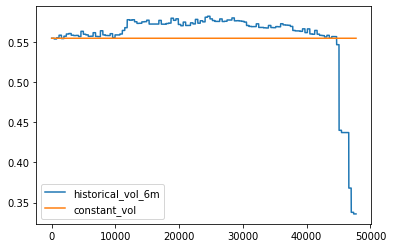

In [462]:
final[['historical_vol_6m', 'constant_vol']].plot()

# Volatility by GARCH(1, 1)

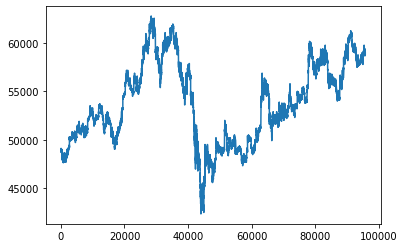

In [396]:
company_name = '삼성'
data = pd.read_csv('./raw_data/'+ company_name + '.csv')
data['close'].plot()

삼성 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.2854981077672668
후기(6개월) 변동성 :  0.2338300978239685
총 기간(1년) 변동성 :  0.2623155442023024


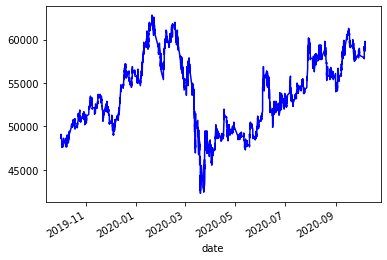

네이버 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.35778236001178315
후기(6개월) 변동성 :  0.33265906182906496
총 기간(1년) 변동성 :  0.3468251229159798


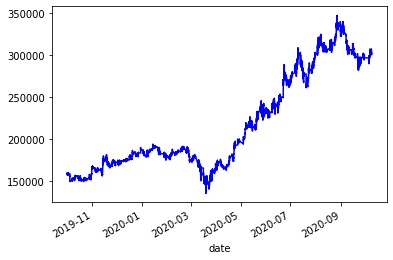

두산중공업 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.5003216640357473
후기(6개월) 변동성 :  0.7620044849744695
총 기간(1년) 변동성 :  0.6531566725759548


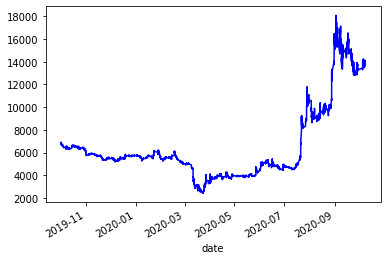

롯데칠성 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.32814852106807696
후기(6개월) 변동성 :  0.2619066354598787
총 기간(1년) 변동성 :  0.2974295409932259


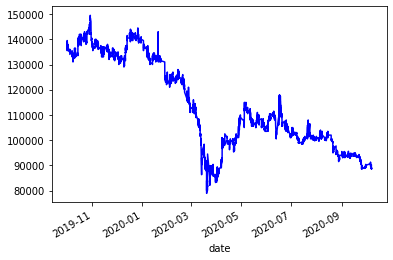

SK네트웍스 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.39337880616575827
후기(6개월) 변동성 :  0.26371918402377176
총 기간(1년) 변동성 :  0.3332501241995625


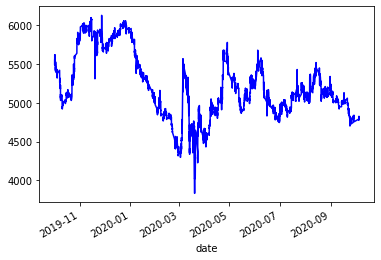

셀트리온헬스케어 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.45873605461247124
후기(6개월) 변동성 :  0.33358926941422684
총 기간(1년) 변동성 :  0.41434169971342094


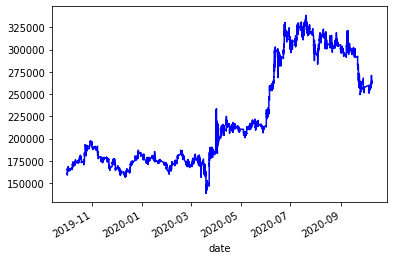

현대건설 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.4538914857882747
후기(6개월) 변동성 :  0.32779936502946194
총 기간(1년) 변동성 :  0.3980698908801952


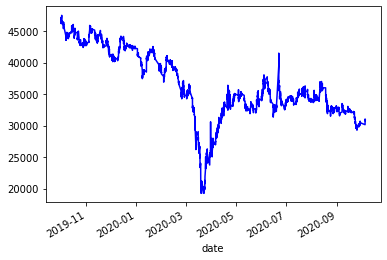

코미팜 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.6730826919816825
후기(6개월) 변동성 :  0.48231776889519784
총 기간(1년) 변동성 :  0.5882105761860837


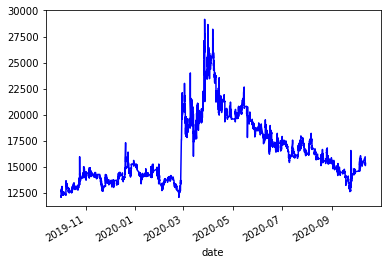

제주항공 변동성추정&투자기간(1년) 변동성
전기(6개월) 변동성 :  0.5543889494163243
후기(6개월) 변동성 :  0.32912320908722864
총 기간(1년) 변동성 :  0.452382627041269


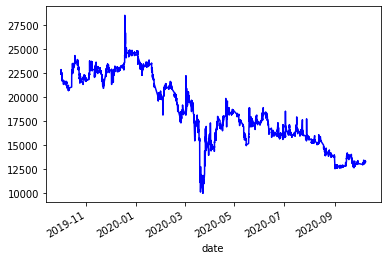

In [463]:
for i in company_list:
    _data = calc_vol(i)

In [448]:
def calc_vol_y(company_name):
    file = company_name+'.csv'
    data = pd.read_csv('./invest_data/' + file)
    data['date'] = pd.to_datetime(data['date'], format = '%Y.%m.%d %H:%M')
    data.index = data.date 
    data.sort_index(inplace=True)
#     data.drop("date", inplace=True, axis =1 )
    half_len = len(data.date.resample("m"))/2
    half_len_round = int(np.round(half_len))
    half_len_df = data.date.resample("m").count().iloc[:half_len_round].sum()
    front_vol = data[:half_len_df].close_y.resample("d").last().pct_change().std() * np.sqrt(252)
    back_vol = data[half_len_df:].close_y.resample("d").last().pct_change().std() * np.sqrt(252)
    total_vol = data[:].close_y.resample("d").last().pct_change().std() * np.sqrt(252)
    print(company_name + " 투자기간(6개월) 앞/뒤 변동성")
    print("전기(3개월) 변동성 :", front_vol)
    print("후기(3개월) 변동성 :", back_vol)
    print("총 투자기간(6개월) 변동성 :", total_vol)
    data.close_y.plot(color = 'red')
    plt.show()
    return data.close_y

삼성 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.25851889546013584
후기(3개월) 변동성 : 0.21846998676330603
총 투자기간(6개월) 변동성 : 0.23811322471783053


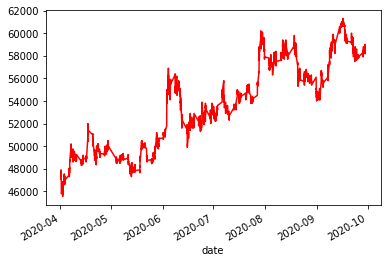

네이버 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.37478971108469217
후기(3개월) 변동성 : 0.29988581937043773
총 투자기간(6개월) 변동성 : 0.3394462825038885


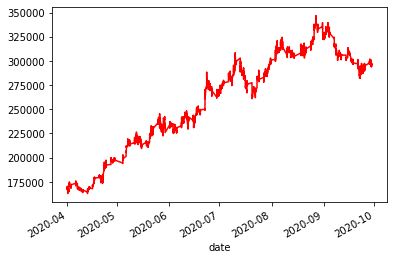

두산중공업 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.48432934171211833
후기(3개월) 변동성 : 0.9865460418869413
총 투자기간(6개월) 변동성 : 0.7776299102296624


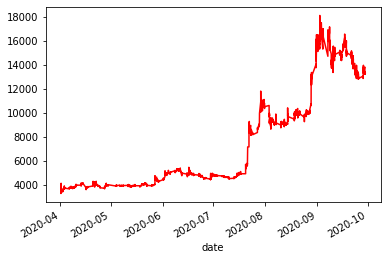

롯데칠성 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.3316144396857855
후기(3개월) 변동성 : 0.17822299112532358
총 투자기간(6개월) 변동성 : 0.2666390342584769


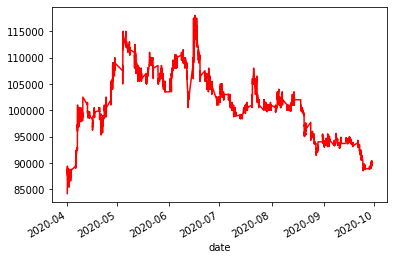

SK네트웍스 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.29880106543201623
후기(3개월) 변동성 : 0.2262936911429555
총 투자기간(6개월) 변동성 : 0.2676170327398787


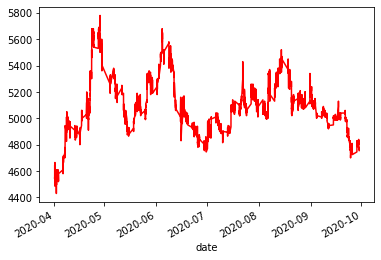

셀트리온헬스케어 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.3691449920274257
후기(3개월) 변동성 : 0.3015870120341596
총 투자기간(6개월) 변동성 : 0.34096956783899324


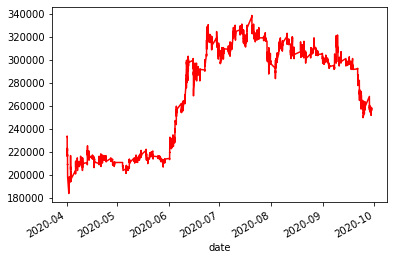

현대건설 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.3943082621517621
후기(3개월) 변동성 : 0.256428186110928
총 투자기간(6개월) 변동성 : 0.33290207272143957


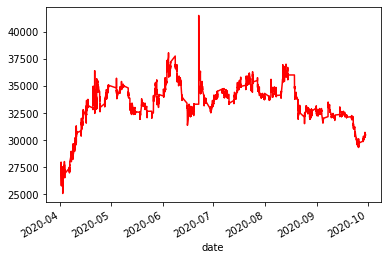

코미팜 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.5107888288434452
후기(3개월) 변동성 : 0.4777058024948979
총 투자기간(6개월) 변동성 : 0.4920184559552274


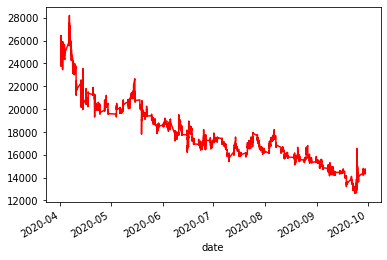

제주항공 투자기간(6개월) 앞/뒤 변동성
전기(3개월) 변동성 : 0.37907107565252635
후기(3개월) 변동성 : 0.28966401408171927
총 투자기간(6개월) 변동성 : 0.3366714720057946


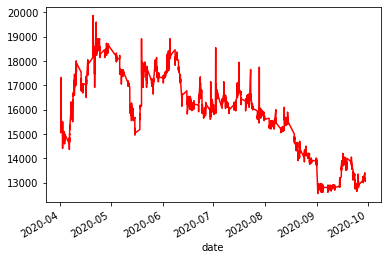

In [464]:
for i in company_list:
    a = calc_vol_y(i)

In [ ]:
삼성.to_csv("삼성.csv")

In [ ]:
두산중공업 = calc_vol("034020")

In [359]:
두산중공업.to_csv("두산중공업.csv")

NameError: name '두산중공업' is not defined

In [ ]:
# 3월 낙폭 적음
셀트리온헬스케어 = calc_vol("068270")

In [ ]:
셀트리온헬스케어.to_csv("셀트리온헬스케어.csv")

In [ ]:
롯데칠성 = calc_vol("005300")

In [ ]:
롯데칠성.to_csv("롯데칠성.csv")

In [ ]:
# 우상향
네이버 = calc_vol("035420")

In [ ]:
네이버.to_csv("네이버.csv")

In [ ]:
# 우하향
현대건설 = calc_vol("000720")

현대건설.to_csv("현대건설.csv")

In [ ]:

SK네트웍스 = calc_vol("001740")

SK네트웍스.to_csv("SK네트웍스.csv")

In [ ]:
# 우하향
셀트리온= calc_vol("068270")

셀트리온.to_csv("셀트리온.csv")

In [ ]:
# 우하향
현대건설 = calc_vol("000720")

현대건설.to_csv("현대건설.csv")

In [ ]:
# rv
# rv = np.sqrt(data[:half_len_df].close.pct_change().pow(2).sum())
# rv